# E01

Tune the hyperparameters of the training to beat my best validation loss of 2.2


In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
words = open('names.txt', 'r').read().splitlines()
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [569]:
def build_dataset(words):
    block_size = 5
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

# train, dev, test
Xtr, Ytr = build_dataset(words[:n1]) 
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])
Xall, Yall = build_dataset(words)

torch.Size([182580, 5]) torch.Size([182580])
torch.Size([22740, 5]) torch.Size([22740])
torch.Size([22826, 5]) torch.Size([22826])
torch.Size([228146, 5]) torch.Size([228146])


In [578]:
# network initialization
block_size = 5
dim_emb = 10 # larger than 10 was better than 10, best result 15, but 20 was not better
dim_hidden = 300 # 1000 was not better than 300, best result 300

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, dim_emb), generator=g)
W1 = torch.randn((block_size * dim_emb, dim_hidden), generator=g)
b1 = torch.randn(dim_hidden, generator=g)
W2 = torch.randn((dim_hidden, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
sum(p.nelement() for p in parameters)

23697

In [579]:
def evaluate_loss(X, Y, printit = False):
    emb = C[X] 
    h = torch.tanh(emb.view(-1, block_size * dim_emb) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    if printit: print(loss.item())
    return loss

In [580]:
# initialization loss
evaluate_loss(Xall, Yall, printit=True)

31.876401901245117


tensor(31.8764, grad_fn=<NllLossBackward0>)

In [581]:
# training

In [582]:
isteps = []
loss_train = []
loss_dev = []

# empirical: larger leads to overfitting, worse dev set results
# best result: 128
minibatch_size = 128 

# this learning rate progression seems to work well across many settings, 
# but was far from ideal for each setting, e.g., training was often too long
lrs = [0.5]*5000 + [0.15]*10000 + [0.1]*5000 + [0.05]*5000 + [0.01]*5000 + [0.005]*5000 + [0.001]*50000
n_steps = len(lrs)

# try to train for a very long time

In [586]:
for i in range(n_steps):
    
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (minibatch_size, )) # but have approximate gradient
    
    # forward pass
    emb = C[Xtr[ix]] 
    h = torch.tanh(emb.view(-1, block_size * dim_emb) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])  + (W1**2).mean() + (W2**2).mean() + (C**2).mean()
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    lr = lrs[i]
    
    for p in parameters:
        p.data += -lr * p.grad

    
    if i%100 == 0:
        isteps.append(i)
        loss_train.append(evaluate_loss(Xtr, Ytr).log10().item())
        loss_dev.append(evaluate_loss(Xdev, Ydev).log10().item())
    
    if i%5000 == 0:
        print('Step ', i, ' Dev loss: ', (10**torch.tensor(loss_dev[-3:])).mean())

Step  0  Dev loss:  tensor(29.8751)
Step  5000  Dev loss:  tensor(2.3453)
Step  10000  Dev loss:  tensor(2.1954)
Step  15000  Dev loss:  tensor(2.1841)
Step  20000  Dev loss:  tensor(2.1634)
Step  25000  Dev loss:  tensor(2.1453)
Step  30000  Dev loss:  tensor(2.1326)
Step  35000  Dev loss:  tensor(2.1313)
Step  40000  Dev loss:  tensor(2.1300)
Step  45000  Dev loss:  tensor(2.1298)
Step  50000  Dev loss:  tensor(2.1296)
Step  55000  Dev loss:  tensor(2.1296)
Step  60000  Dev loss:  tensor(2.1297)
Step  65000  Dev loss:  tensor(2.1299)
Step  70000  Dev loss:  tensor(2.1298)
Step  75000  Dev loss:  tensor(2.1295)
Step  80000  Dev loss:  tensor(2.1295)


In [587]:
evaluate_loss(Xtr, Ytr, printit=True)
evaluate_loss(Xdev, Ydev, printit=True)

2.1053969860076904
2.129359483718872


tensor(2.1294, grad_fn=<NllLossBackward0>)

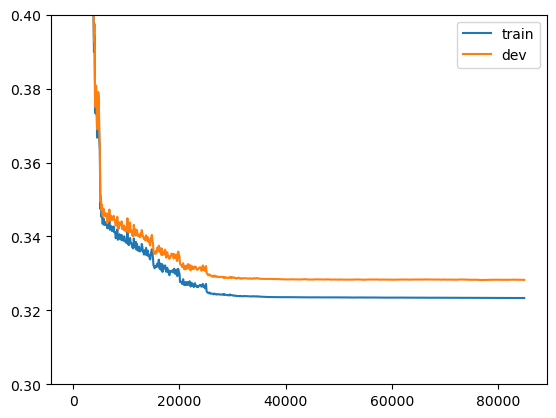

In [588]:
plt.plot(isteps, loss_train, isteps, loss_dev)
plt.ylim([0.3, 0.4])
plt.legend(['train', 'dev']);

In [591]:
(C**2).mean()

tensor(0.0341, grad_fn=<MeanBackward0>)

In [551]:
loss

tensor(2.2157, grad_fn=<AddBackward0>)

In [592]:
# final: evaluate loss on test set
evaluate_loss(Xte, Yte)

tensor(2.1257, grad_fn=<NllLossBackward0>)

# E02

I was not careful with the intialization of the network in this video. 

1. What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? 
2. Can you tune the initialization to get a starting loss that is much more similar to (1)?


In [316]:
# 1. We got loss of 26
# uniform probabilities (assuming each of 27 characters gets probability 1/27)
logits = torch.tensor([1/27]*Yall.shape[0]*27).view(-1, 27).float().log()
loss = F.cross_entropy(logits, Yall)
print(loss.item())

3.295837163925171


In [424]:
# 2. Tuning the network initialization, by changing the random initializations of the weights and biases
block_size = 3
dim_emb = 10
dim_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.rand((27, dim_emb), generator=g)
W1 = torch.rand((block_size * dim_emb, dim_hidden), generator=g)
b1 = torch.rand(dim_hidden, generator=g)
W2 = torch.randn((dim_hidden, 27), generator=g)/100
#b2 = torch.rand(27, generator=g)
b2 = torch.tensor(1/27).log()
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
sum(p.nelement() for p in parameters)

h = torch.tanh(emb.view(-1, block_size * dim_emb) @ W1 + b1) 
# h is on [0, 1], but many values at 0 and at 1 -> mean 0 (guess)
# hence logits has small standard deviation if W2 and b2 have small standard deviation
# mean of logits is then mean of b2 -> set b2 deterministic log(1/27)
logits = h @ W2 + b2 # logits should be close together for uniform 1/27 distribution

def evaluate_loss(X, Y, printit = False):
    emb = C[X] 
    h = torch.tanh(emb.view(-1, block_size * dim_emb) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    if printit: print(loss.item())
    return loss


evaluate_loss(Xall, Yall, printit=True)

3.368262529373169


tensor(3.3683, grad_fn=<NllLossBackward0>)

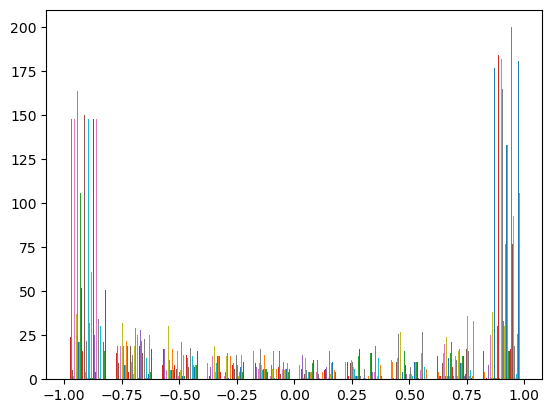

In [417]:
plt.hist(h.detach());

# E03

Read the Bengio et al 2003 paper (link above), implement and try any idea from the paper. Did it work?

Potential improvements mentioned in the paper:
* weight decay penalty (squared norm of parameters, applied only to the weights of the neural network and to the C matrix)
  * I got to maybe 2.18 loss on the dev set by playing around with number the dimension of the embedding, the size of the hidden layer. With weight normalization I got around 2.15 on dev, 2.16 on test. Increasing block length to 5 gave test error of 2.125

Not tried:
* recurrent neural network instead of feed-forward network
* direct connections from embedding to output layer
* ensemble: combining the probability predictions of the neural network with those of an interpolated trigram model
* the concrete parameterization of MLP10
* question to self: what is perplexity
* train on more data (more names) evaluate on test set from this dataset (first making sure, the additional data does not contain words from the test set)
* Interpreting character embedding vectors (as was already done to some extend in the video)
* for each character, have not one, but several embedding vectors

There were other potential improvements mentioned, but either I found them too extensive as to be considered here (e.g., going to a different paper to try to improve speed by a factor of 100, or implementing parallel processing), or I did not really understand what was meant (e.g., the graph neural net approach).

Summary
Part 1
Introduction to forward pass and backward pass (backpropagation) for some common operations

Part 1 - Exercises
analytical and numerical gradients
backward passes for various operations (log, exp, division, negation)
reproduction of the gradient from torch.Tensor in an example

Part 2
bigram character-level language model
torch.Tensor 
the overall framework of language modeling that includes model training, sampling, and the evaluation of a loss (e.g. the negative log likelihood for classification)

Part 2 - Exercises
Trigram language model counting approach
trigram language model neural net (with 1 layer) approach
reproducing pytorch cross entropy losses (for class indices and class probabilities) and negative log likelihood loss for classes (1 dimensional case) and for image data (2 dimensional case)
Visualization of changes in the weight matrix during 100 gradient descent operations
Reproducing the pytorch Conv2d layer for an example

Part 3 
Reading Bengio et. al. "A Neural Probabilistic Language Model", from 2003. Following it, implementing a multilayer perceptron for next character prediction (character-level language model) with one hidden layer. 
Basic concepts of machine learning: model training, learning rate tuning, choice of hyperparameters, model evaluation, train/dev/test splits, under/overfitting.

